# Quantum chemistry on the QLM

## Example: $LiH$ molecule

Let us now study the molecule $LiH$. As for the $H_2$ case (studied in a previous tutorial), we need to first describe the geometry and atomic content of the molecule. In this example, we will compute the basis change and select the active space.

We extract the data from the included resource file. These data were computed using the PySCF package.

In [1]:
import numpy as np

lih_data = np.load("lih_data.npz", allow_pickle=True)

rdm1 = lih_data["rdm1"]
orbital_energies = lih_data["orbital_energies"]
nuclear_repulsion = lih_data["nuclear_repulsion"]
n_electrons = lih_data["n_electrons"]
one_body_integrals = lih_data["one_body_integrals"]
two_body_integrals = lih_data["two_body_integrals"]
info = lih_data["info"].tolist()

nqbits = rdm1.shape[0] * 2

print(
    f" HF energy :  {info['HF']}\n",
    f"MP2 energy : {info['MP2']}\n",
    f"FCI energy : {info['FCI']}\n",
)
print(f"Number of qubits before active space selection = {rdm1.shape[0] * 2}")
print("Number of qubits = ", nqbits)

 HF energy :  -7.978244325721493
 MP2 energy : -7.991271632153254
 FCI energy : -7.998354311186427

Number of qubits before active space selection = 22
Number of qubits =  22


### Note: PySCF

If you have the PySCF package installed, you can do the previous computation yourself using our `perform_pyscf_computation`function.

```python
from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation

geometry = [("Li", (0.0, 0.0, 0.0)), ("H", (0.0, 0.0, 1.75))]
basis = "6-31g"
spin = 0
charge = 0

(
    rdm1,
    orbital_energies,
    nuclear_repulsion,
    n_electrons,
    one_body_integrals,
    two_body_integrals,
    info,
) = perform_pyscf_computation(geometry=geometry, basis=basis, spin=spin, charge=charge)

# We give the full CI energy computed on the QLM for LiH
info["FCI"] = -7.998354311186427

print(
    f" HF energy :  {info['HF']}\n",
    f"MP2 energy : {info['MP2']}\n",
    f"FCI energy : {info['FCI']}\n",
)
print(f"Number of qubits before active space selection = {rdm1.shape[0] * 2}")

nqbits = rdm1.shape[0] * 2
print("Number of qubits = ", nqbits)
```

We wrap the body integrals and the nuclear repulsion in the `MolecularHamiltonian` class:

In [2]:
from qat.fermion.chemistry import MolecularHamiltonian, MoleculeInfo

# Define the molecular hamiltonian
mol_h = MolecularHamiltonian(one_body_integrals, two_body_integrals, nuclear_repulsion)

print(mol_h)

 MolecularHamiltonian(
 - constant_coeff : 0.9071609330057144
 - integrals shape
    * one_body_integrals : (11, 11)
    * two_body_integrals : (11, 11, 11, 11)
)


## Active space selection

Based on the (approximate) one-particle reduced density matrix computed (``rdm1``), we compute the so-called "natural-orbital occupation numbers" (NOONs). We use them to select, with a given threshold, the "active space orbitals" (which are contained in the ``active_indices`` list below). We then compute the Hamiltonian in this active space.

In [3]:
# Compute the natural orbitals occupation numbers and the basis transformation matrix
noons, basis_change = np.linalg.eigh(rdm1)

# The noons should be in decreasing order
noons = list(reversed(noons))

# Since we reversed the noons, we have to flip the basis as well
basis_change = np.flip(basis_change, axis=1)

The basis change can be done within the `MolecularHamiltonian` class:

In [4]:
# Change the hamiltonian basis
mol_h_new_basis = mol_h.transform_basis(basis_change)

The `MoleculeInfo` class is a helper class which contains various molecule properties.

In [5]:
molecule = MoleculeInfo(
    mol_h_new_basis,
    n_electrons=n_electrons,
    noons=noons,
    orbital_energies=orbital_energies,
)

In [6]:
molecule

MoleculeInfo(
 - MolecularHamiltonian(
    * constant_coeff : 0.9071609330057144
    * integrals shape
       ** one_body_integrals : (11, 11)
       ** two_body_integrals : (11, 11, 11, 11)
   )
 - n_electrons = 4
 - noons = [1.999908803582278, 1.9490174404821416, 0.04680924206971765, 0.0018388291832408565, 0.0009388060306067255, 0.0009388060306067249, 0.000498740509127347, 2.53154537304913e-05, 1.1601438714599513e-05, 1.1601438714598397e-05, 8.137811217332868e-07]
 - orbital energies = [-2.46481078 -0.29198191  0.00584726  0.05830485  0.05830485  0.14705508
  0.19900943  0.21877097  0.21877097  0.32774881  1.30468514]
)

 The `MoleculeInfo.restrict_active_space()` method updates the class to the new computed active space.

In [7]:
# Selection of the active space
molecule.restrict_active_space(threshold_1=0.02, threshold_2=0.002)

In [8]:
molecule

MoleculeInfo(
 - MolecularHamiltonian(
    * constant_coeff : 0.9071609330057144
    * integrals shape
       ** one_body_integrals : (2, 2)
       ** two_body_integrals : (2, 2, 2, 2)
   )
 - n_electrons = 2
 - noons = [1.9490174404821416, 0.04680924206971765]
 - orbital energies = [-0.29198190623310005, 0.005847259432339362]
)

## Computation of cluster operators $T$ and good guess $\vec{\theta}_0$

We construct the cluster operators (``cluster_ops``) $\hat{T}(\vec{\theta})$, as well as a good starting parameter $\vec{\theta}$ (based on the second order Møller-Plesset perturbation theory).

In [9]:
from qat.fermion.chemistry.ucc import guess_init_params, get_hf_ket, get_cluster_ops

# Compute the cluster operators
cluster_ops = get_cluster_ops(molecule.n_electrons, noons=molecule.noons)

In [10]:
# Computation of the initial  parameters
theta_list = guess_init_params(
    molecule.two_body_integrals,
    molecule.n_electrons,
    molecule.orbital_energies,
)

print(f"List of initial parameters : {theta_list}")

List of initial parameters : [0, 0, 0.19640341508488024]


In [11]:
# Define the initial Hartree-Fock state
ket_hf_init = get_hf_ket(molecule.n_electrons, nqbits=molecule.nqbits)
print(f"Initial Hartree-Fock state : {ket_hf_init}")

Initial Hartree-Fock state : 12


## Encode to qubits: Fermion-spin transformation

We transform the fermionic operators to spin (or qubit) space. In this example we choose the Bravyi-Kitaev transform.

In [12]:
from qat.fermion.transforms import transform_to_bk_basis

# Compute the ElectronicStructureHamiltonian
H_active = molecule.hamiltonian.get_electronic_hamiltonian()

# Transform the ElectronicStructureHamiltonian into a spin Hamiltonian
H_active_sp = transform_to_bk_basis(H_active)

In [13]:
from qat.fermion.transforms import recode_integer, get_bk_code

# Express the cluster operator in spin terms
cluster_ops_sp = [transform_to_bk_basis(t_o) for t_o in cluster_ops]

# Encoding the initial state to new encoding
hf_init_sp = recode_integer(ket_hf_init, get_bk_code(H_active_sp.nbqbits))

## Trotterize the Hamiltonian to get the parameterized circuit to optimize

In [14]:
from qat.lang.AQASM import Program, X
from qat.fermion.trotterisation import make_trotterisation_routine

nqbits = cluster_ops_sp[0].nbqbits

prog = Program()
reg = prog.qalloc(nqbits)

# Initialize the Hartree-Fock state into the Program
for j, char in enumerate(format(hf_init_sp, "0" + str(nqbits) + "b")):
    if char == "1":
        prog.apply(X, reg[j])

# Define the parameters to optimize
theta = [prog.new_var(float, "\\theta_{%s}" % i) for i in range(len(cluster_ops))]

# Define the parameterized Hamiltonian
hamiltonian = sum([th * T for th, T in zip(theta, cluster_ops_sp)])

# Trotterize the Hamiltonian (with 1 trotter step)
qrout = make_trotterisation_routine(hamiltonian, n_trotter_steps=1, final_time=1)

prog.apply(qrout, reg)
circ = prog.to_circ()

Alternatively, you can simply use the `construct_ucc_ansatz` fonction:

In [15]:
from qat.fermion.chemistry.ucc import construct_ucc_ansatz

prog = construct_ucc_ansatz(cluster_ops_sp, hf_init_sp, n_steps=1)
circ = prog.to_circ()

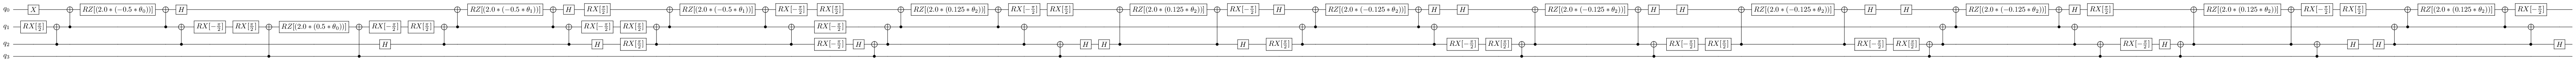

In [16]:
circ.display()

## Optimize the angles of $\psi(\vec{\theta})$ for a given QPU

We can now use the QLM's variational plugins to perform the VQE optimization.

In [17]:
job = circ.to_job(job_type="OBS", observable=H_active_sp, nbshots=0)

from qat.qpus import get_default_qpu
from qat.vsolve.optimize import ScipyMinimizePlugin

optimizer_scipy = ScipyMinimizePlugin(method="COBYLA", tol=1e-3, options={"maxiter": 1000}, x0=theta_list)
qpu = optimizer_scipy | get_default_qpu()
result = qpu.submit(job)

print("Minimum energy =", result.value)
print("FCI energy:", info["FCI"])

Minimum energy = -7.995936018596893
FCI energy: -7.998354311186427


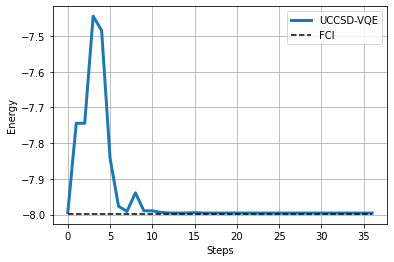

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(eval(result.meta_data["optimization_trace"]), label="UCCSD-VQE", lw=3)
plt.plot(
    [info["FCI"] for _ in range(len(eval(result.meta_data["optimization_trace"])))],
    "--k",
    label="FCI",
)
plt.legend(loc="best")
plt.xlabel("Steps")
plt.ylabel("Energy")
plt.grid()

# Solving $LiH$ using ADAPT-VQE plugin

We can use the **ADAPT-VQE** plugin to generate iteratively the ansatz which minimizes the energy. Assuming we have our Hamiltonian in the selected active space (`H_active`), we need to initialize the circuit with the corresponding Hartree-Fock state.

The plugin `AdaptVQEPlugin` generates automatically the ansatz, which needs to be optimized using an optimizer. Here, we will use once again `ScipyMinimizePlugin`, coupled to the QPU.

In [19]:
from qat.plugins import AdaptVQEPlugin

# Initialize a Program
prog = Program()
reg = prog.qalloc(H_active_sp.nbqbits)

# Define the circuit which prepares a Hartree-Fock state
for j, char in enumerate(format(hf_init_sp, "0" + str(H_active_sp.nbqbits) + "b")):
    if char == "1":
        prog.apply(X, reg[j])

circuit = prog.to_circ()

# We have the variational Job we need to optimize
job = circuit.to_job(observable=H_active_sp)

# We define the stack...
adaptvqe_plugin = AdaptVQEPlugin(cluster_ops_sp, n_iterations=15, early_stopper=1e-6)
optimizer = ScipyMinimizePlugin(method="COBYLA", tol=1e-3, options={"maxiter": 200}, x0=theta_list)
qpu = get_default_qpu()

stack = adaptvqe_plugin | optimizer | qpu

# ... and submit the job
result_adapt = stack.submit(job)

Computing commutators...:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

/tmp/ipykernel_107111/3176836110.py:25: UserWarning: All energy gradients are equal to zero for given operator pool. Ending calculation.
  result_adapt = stack.submit(job)


Let us plot the result and compare the convergence with the previous optimization.

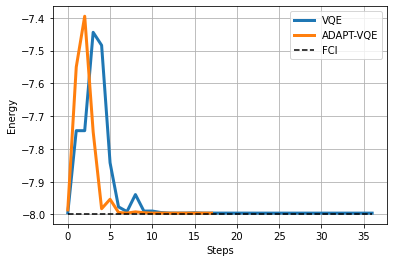

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(eval(result.meta_data["optimization_trace"]), label="VQE", lw=3)
plt.plot(eval(result_adapt.meta_data["optimization_trace"]), label="ADAPT-VQE", lw=3)
plt.plot(
    [info["FCI"] for _ in enumerate(eval(result.meta_data["optimization_trace"]))],
    "--k",
    label="FCI",
)
plt.legend(loc="best")
plt.xlabel("Steps")
plt.ylabel("Energy")
plt.grid()

## Annex : Active space selection using only the `MolecularHamiltonian`class

To explain better what is happening under the hood, let us select the active space of the $LiH$ molecule without using the `MoleculeInfo` class. Let us assume we already used `perform_pyscf_computation` to compute the molecule properties we need.

In [21]:
# We define the molecular hamiltonian
mol_h = MolecularHamiltonian(one_body_integrals, two_body_integrals, nuclear_repulsion)

print(mol_h)

# We compute the natural orbitals occupation numbers and the basis transformation matrix
noons, basis_change = np.linalg.eigh(rdm1)

# Reverse the noons order for them to be in decreasing order...
noons = list(reversed(noons))

# ... and flip the basis as well
basis_change = np.flip(basis_change, axis=1)

 MolecularHamiltonian(
 - constant_coeff : 0.9071609330057144
 - integrals shape
    * one_body_integrals : (11, 11)
    * two_body_integrals : (11, 11, 11, 11)
)


We use `MolecularHamiltonian.select_active_space()` to select an active space. This will update the body integrals as well as the constant coefficient in the `MolecularHamiltonian`class (here `mol_h_active`).

In [22]:
# Active space selection
mol_h_active, active_indices, occupied_indices = mol_h_new_basis.select_active_space(
    noons=noons, n_electrons=n_electrons, threshold_1=0.02, threshold_2=0.002
)

print(mol_h_active)

# The number of qubits can be computed from the one body integral in the active space:
nqbits = mol_h_active.one_body_integrals.shape[0] * 2

print(f"We reduced the number of qubits from {mol_h.one_body_integrals.shape[0] * 2} to only {nqbits} !")

 MolecularHamiltonian(
 - constant_coeff : 0.9071609330057144
 - integrals shape
    * one_body_integrals : (2, 2)
    * two_body_integrals : (2, 2, 2, 2)
)
We reduced the number of qubits from 22 to only 4 !


We get the `active_indices` and the `occupied_indices`. The `MoleculeInfo` takes care of everything for us by overwriting the correct attributes with their updated **active** counterparts. But since we are not going to use it, we need to do it manually:

In [23]:
active_noons = [noons[idx] for idx in active_indices]
active_orbital_energies = [orbital_energies[idx] for idx in active_indices]
active_n_electrons = n_electrons - 2 * len(occupied_indices)

We can then do as usual, by calling directly the functions we need. For example we can guess the optimal initial parameter:

In [24]:
# Computation of the initial parameters
theta_list = guess_init_params(
    mol_h_active.two_body_integrals,
    active_n_electrons,
    active_orbital_energies,
)

print(f"List of initial parameters : {theta_list}")

# Get the initial Hartree-Fock state
ket_hf_init = get_hf_ket(active_n_electrons, nqbits=nqbits)

print(f"Initial Hartree-Fock state : {ket_hf_init}")

# Compute the cluster operators
cluster_ops = get_cluster_ops(molecule.n_electrons, noons=active_noons)

List of initial parameters : [0, 0, 0.19640341508488024]
Initial Hartree-Fock state : 12


You are then free to convert the `MolecularHamiltonian` to an `ElectronicStructureHamiltonian` just as in the `MoleculeInfo`part by doing:

In [25]:
# Get the ElectronicStructureHamiltonian
H_active = mol_h_active.get_electronic_hamiltonian()

## Further questions to be investigated:

This notebook only tackles certain aspects of performing chemistry on the QLM. Other questions that you can deal with using other QLM tools include:

- what are the effects of noise on the VQE ?
- how do noisy and noiseless VQE compare ?
- what is the effect of the QPU connectivity constraints (e.g. IBM QX5 chip) ? 
- how to reduce the gate count given a topology?
- how to rewrite a circuit for another gate set (say, for ions)?
- how to mitigate noise effects? (zero-noise extrapolation...)